In [ ]:
import gdown, zipfile, os

file_id = '1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV'

gdown.download(f'https://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'car'
os.makedirs(dir, exist_ok=True) # 이미 있으면 넘어가고, 없으면 새로 생성

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)


Downloading...
From (original): https://drive.google.com/uc?id=1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV
From (redirected): https://drive.google.com/uc?id=1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV&confirm=t&uuid=743e968c-aa13-42f4-b20e-457753609bac
To: /content/file.zip
100%|██████████| 1.20G/1.20G [00:21<00:00, 56.5MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# flow_from_DataFrame
import numpy as np
import pandas as pd
import os

base_dir = 'car'

paths = []
dataset_types = []
labels = []

# os.walk() 특정 디렉토리 하위의 디렉토리/파일을 재귀적으로 탐색
for dir_name, sub_dirs, file_names in os.walk(base_dir):
  # print(dir_name)
  # print(sub_dirs)
  # print(file_names)
  for file_name in file_names:
    # print(file_name)
    if '.jpg' in file_name:
      file_path = f'{dir_name}/{file_name}'
      paths.append(file_path)

      if 'Training' in dir_name:
        dataset_types.append('train')
      else:
        dataset_types.append('test')

      if 'SUV' in dir_name:
        labels.append('SUV')
      elif 'Sedan' in dir_name:
        labels.append('Sedan')
      elif 'Truck' in dir_name:
        labels.append('Truck')
      else:
        labels.append('Van')

data_df = pd.DataFrame({
    'path': paths,
    'dataset_type': dataset_types,
    'label': labels
})

data_df.shape, data_df.info(), data_df.describe()

data_df
data_df['dataset_type'].value_counts()
data_df['label'].value_counts()
data_df[['dataset_type', 'label']].value_counts()
data_df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   path          65532 non-null  object
 1   dataset_type  65532 non-null  object
 2   label         65532 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB


,count
label,
Sedan,42517
SUV,14484
Truck,4525
Van,4006


In [ ]:
def show_img(path, title=None):
  fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(32, 6))
  for i in range(8):
    img = cv2.imread(path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    if title:
      ax[i].set_title(title)
    ax[i].axis('off')
  plt.show()

SUV_paths = data_df[data_df['label'] == 'SUV']['path'].values
Sedan_paths = data_df[data_df['label'] == 'Sedan']['path'].values
Truck_paths = data_df[data_df['label'] == 'Truck']['path'].values
Van_paths = data_df[data_df['label'] == 'Van']['path'].values

show_img(SUV_paths[0:8], title='SUV')
show_img(Sedan_paths[0:8], title='Sedan')
show_img(Truck_paths[0:8], title='Truck')
show_img(Van_paths[0:8], title='Van')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.model_selection import train_test_split

train_df = data_df[data_df['dataset_type'] == 'train']
test_df = data_df[data_df['dataset_type'] == 'test']

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=0)

train_df.shape, val_df.shape, test_df.shape

((40863, 3), (10216, 3), (14453, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model

In [ ]:
# 데이터셋 별로 ImageDataGenerator, flow_gen 객체 작업
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 224
BATCH_SIZE = 64

tr_data_gen = ImageDataGenerator(
    rescale = 1/255.0,
    horizontal_flip=True
)

val_data_gen = ImageDataGenerator(
    rescale = 1/255.0
)

test_data_gen = ImageDataGenerator(
    rescale = 1/255.0
)

tr_flow_gen = tr_data_gen.flow_from_dataframe(
    train_df,
    x_col = 'path',
    y_col = 'label', # SUV/Sedan/Truck/Van
    class_mode = 'sparse',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True
)

val_flow_gen = val_data_gen.flow_from_dataframe(
    train_df,
    x_col = 'path',
    y_col = 'label',
    class_mode = 'sparse',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False
)

test_flow_gen = test_data_gen.flow_from_dataframe(
    test_df,
    x_col = 'path',
    y_col = 'label',
    class_mode = 'sparse',
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False
)

Found 40863 validated image filenames belonging to 4 classes.
Found 40863 validated image filenames belonging to 4 classes.
Found 14453 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.initializers import he_normal


def create_model(verbose=False):
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) # cifar10 이미지 크기
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    # 마지막 특성맵의 크기 줄이기 기법 (pooling대신 strides=2 사용)
    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # 이전 채널수가 충분한 경우 GlobalAveragePooling을 Flatten대신 사용해볼 수 있다.
    # x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=1024, kernel_initializer='he_normal', activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)

    if verbose:
        model.summary()

    return model

model = create_model(verbose=True)




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,5

 Total params: 2,887,716 (11.02 MB)

 Trainable params: 2,884,772 (11.00 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152V2


early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

model_check_point_cb = ModelCheckpoint(
    filepath='./result/checkpoint.{epoch:02d}-{val_loss:.2f}.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    verbose=1
)

base_model = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    tr_flow_gen,
    validation_data=val_flow_gen,
    epochs=15,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb]
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 353s 491ms/step - accuracy: 0.7818 - loss: 0.6023 - val_accuracy: 0.6776 - val_loss: 0.8347 - learning_rate: 0.0010
Epoch 2/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 295s 461ms/step - accuracy: 0.9338 - loss: 0.2015 - val_accuracy: 0.9032 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 3/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 297s 463ms/step - accuracy: 0.9482 - loss: 0.1527 - val_accuracy: 0.9520 - val_loss: 0.1415 - learning_rate: 0.0010
639/639 ━━━━━━━━━━━━━━━━━━━━ 297s 463ms/step - accuracy: 0.9482 - loss: 0.1527 - val_accuracy: 0.9520 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 4/15
Epoch 4/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 323s 464ms/step - accuracy: 0.9630 - loss: 0.1157 - val_accuracy: 0.8919 - val_loss: 0.3146 - learning_rate: 0.0010
639/639 ━━━━━━━━━━━━━━━━━━━━ 323s 464ms/step - accuracy: 0.9630 - loss: 0.1157 - val_accuracy: 0.8919 - val_loss: 0.3146 - learning_rate: 0.0010
Epoch 5/15
Epoch 5/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 299s 465ms/step - accuracy: 0.9646 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.9686 - loss: 0.1347
0.13768263161182404 0.9688646197319031


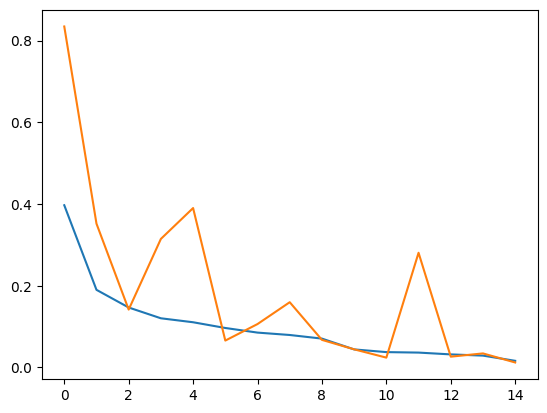

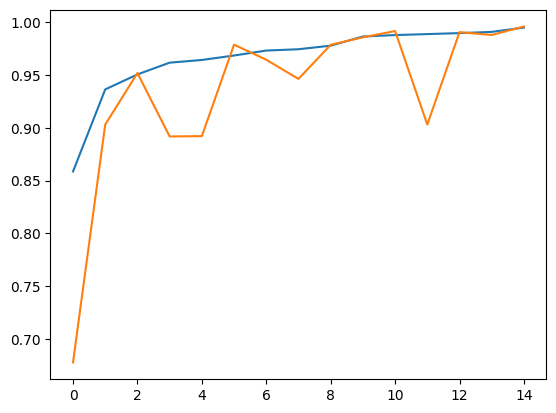

In [ ]:
loss, accuracy = model.evaluate(test_flow_gen)

print(loss, accuracy)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()